In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import string
import pickle
import random
import tarfile
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
trainingmodule_dir = '/content/drive/MyDrive/capstone/'

europarlv7_de = os.path.join(trainingmodule_dir, 'europarl-v7_de_en.txt')
europarlv7_en = os.path.join(trainingmodule_dir, 'europarl-v7_en_de.txt')
commoncrawlv1_de = os.path.join(trainingmodule_dir, 'commoncrawl_de_en.txt')
commoncrawlv1_en = os.path.join(trainingmodule_dir, 'commoncrawl_en_de.txt')

In [ ]:
def load_dataset(de_path, en_path):
    # Load parallel sentences from two text files and create a DataFrame.
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

    # Check if lengths match
    if len(de_sentences) != len(en_sentences):
        print(f"Length mismatch: {de_path} ({len(de_sentences)}) and {en_path} ({len(en_sentences)})")
        # Truncate to the shorter length
        min_length = min(len(de_sentences), len(en_sentences))
        de_sentences = de_sentences[:min_length]
        en_sentences = en_sentences[:min_length]

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

# Load datasets
europarl_f = load_dataset(europarlv7_de, europarlv7_en)
commoncrawl_f = load_dataset(commoncrawlv1_de, commoncrawlv1_en)

In [ ]:
#Print the shape of each dataset
print("Shape of Europarl German dataset :",europarl_f.shape)

Shape of Europarl German dataset : (1920209, 2)


In [ ]:
print("Shape of CommonCarl German dataset :",commoncrawl_f.shape)

Shape of CommonCarl German dataset : (2399123, 2)


In [ ]:
# Merge the datasets
df = pd.concat([europarl_f, commoncrawl_f], ignore_index=True)

# Display the number of sentences
print(f"Total number of sentences in the dataset: {len(df)}")

Total number of sentences in the dataset: 4319332


In [ ]:
# Display entire dataframe
pd.set_option('display.max_colwidth', None)  # Display full contents of each column without truncation
pd.set_option('display.max_rows', None)      # Display all rows

In [ ]:
df.head(20)

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"
5,"Ich bitte Sie, sich zu einer Schweigeminute zu erheben.\n","Please rise, then, for this minute' s silence.\n"
6,(Das Parlament erhebt sich zu einer Schweigeminute.)\n,(The House rose and observed a minute' s silence)\n
7,"Frau Präsidentin, zur Geschäftsordnung.\n","Madam President, on a point of order.\n"
8,"Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.\n",You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.\n
9,"Zu den Attentatsopfern, die es in jüngster Zeit in Sri Lanka zu beklagen gab, zählt auch Herr Kumar Ponnambalam, der dem Europäischen Parlament erst vor wenigen Monaten einen Besuch abgestattet hatte.\n","One of the people assassinated very recently in Sri Lanka was Mr Kumar Ponnambalam, who had visited the European Parliament just a few months ago.\n"


In [ ]:
# Taking 5000 from each dataset to proceed with machine translation
europarl_f = europarl_f.sample(n=5000, random_state=42)
commoncrawl_f = commoncrawl_f.sample(n=5000, random_state=42)
# Merge the datasets
merged_df = pd.concat([europarl_f, commoncrawl_f], ignore_index=True)

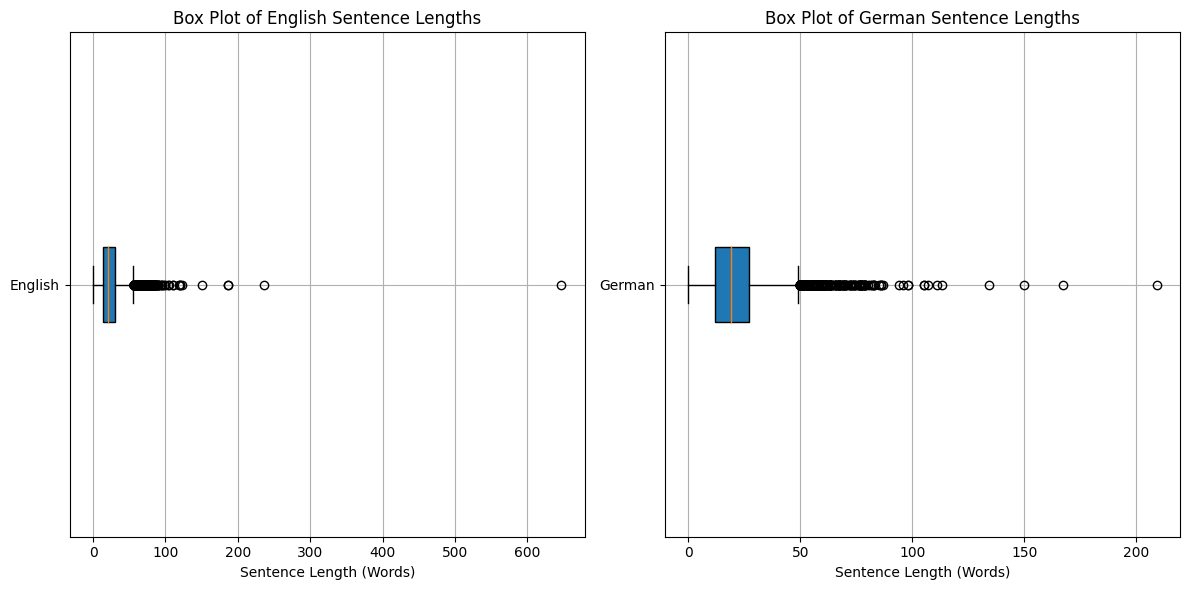

In [ ]:
english_sentences = merged_df["English"].tolist()
german_sentences = merged_df["German"].tolist()

# Calculate sentence lengths
english_lengths = [len(sentence.split()) for sentence in english_sentences]
german_lengths = [len(sentence.split()) for sentence in german_sentences]

# Create a histogram plot with two subplots
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Side-by-side box plots for English and German lengths
plt.subplot(1, 2, 1)
plt.boxplot(english_lengths, vert=False, patch_artist=True, labels=['English'])
plt.xlabel("Sentence Length (Words)")
plt.title("Box Plot of English Sentence Lengths")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(german_lengths, vert=False, patch_artist=True, labels=['German'])
plt.xlabel("Sentence Length (Words)")
plt.title("Box Plot of German Sentence Lengths")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def cleanse_dataset(dataset):
    dataset = dataset[(dataset['German'].str.strip() != '') & (dataset['English'].str.strip() != '')]
    dataset.loc[:, 'German'] = dataset['German'].str.strip()
    dataset.loc[:, 'English'] = dataset['English'].str.strip()
    dataset = dataset.drop_duplicates()
    dataset.loc[:, 'German'] = dataset['German'].str.replace(r'[^a-zA-ZäöüßÄÖÜéèêàâçÇ\s]', '', regex=True)
    dataset.loc[:, 'English'] = dataset['English'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
    dataset.loc[:, 'German'] = dataset['German'].str.lower()
    dataset.loc[:, 'English'] = dataset['English'].str.lower()
    return dataset

In [ ]:
cleanse_df = cleanse_dataset(merged_df)
cleanse_df.shape

(9956, 2)

In [ ]:
def rem_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
cleanse_df['German'] = cleanse_df['German'].apply(rem_punctuation)
cleanse_df['English'] = cleanse_df['English'].apply(rem_punctuation)

In [ ]:
cleanse_df.head(5)

,German,English
0,falls es legal ist dann brauchen wir keine debatte zur führen,if it is legal we do not need a debate
1,weitere makrofinanzhilfe für georgien,further macrofinancial assistance for georgia
2,diese forderung verlief im sande zum einen weil das abkommen im juli ausläuft und zum anderen weil wir der ansicht waren dass ein so sensibles thema wie die dauer der vorratsspeicherung erforderlichenfalls gegenstand späterer verhandlungen sein könnte,the request came to nothing firstly because the agreement will come to an end in july and secondly because we have taken the view that a subject as sensitive as the period of data retention could if necessary be a topic for later negotiations
3,so funktioniert der rechtsstaat und lord bethell kann sicher sein dass das dänische rechtswesen entsprechend den prinzipien funktioniert die wir in dieser union hochhalten,that is how the judicial system works and lord bethell can be certain that the danish legal system functions in accordance with all the principles that we uphold in this union
4,wir sind daher durch die weigerung des rates die grundrechtecharta rechtsverbindlich zu machen in eine absurde situation geraten einerseits werden die grundrechte als zwingende konsequenz der anerkennung der würde des menschen betrachtet aber andererseits wird es den menschen verweigert sie tatsächlich als ihr recht geltend machen zu können,the councils refusal to make the charter of fundamental rights binding in law therefore puts us in an absurd situation in which on the one hand fundamental rights are regarded as an inevitable consequence of the recognition of human dignity whilst on the other hand people are denied the chance to exercise their rights


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Embedding, LSTM, TimeDistributed, Input, SimpleRNN, Bidirectional, Dense, RepeatVector, Concatenate, Attention, Dot, Activation
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
preprocessed_1_df = cleanse_df
train_df, test_df = train_test_split(preprocessed_1_df, test_size=0.2, random_state=42)
train_german = train_df['German']
train_english = train_df['English']
test_german = test_df['German']
test_english = test_df['English']
tokenizer_german = Tokenizer()
tokenizer_english = Tokenizer()
tokenizer_german.fit_on_texts(train_german)
tokenizer_english.fit_on_texts(train_english)

train_german_sequences = tokenizer_german.texts_to_sequences(train_german)
train_english_sequences = tokenizer_english.texts_to_sequences(train_english)
test_german_sequences = tokenizer_german.texts_to_sequences(test_german)
test_english_sequences = tokenizer_english.texts_to_sequences(test_english)

In [ ]:
# Check language length
german_vocab = len(tokenizer_german.word_index) + 1
english_vocab = len(tokenizer_english.word_index) + 1

In [ ]:
max_ger_len = int(len(max(train_german_sequences,key=len)))
max_eng_len = int(len(max(train_english_sequences,key=len)))
max_len = max(max_ger_len, max_eng_len)

train_german_padded = pad_sequences(train_german_sequences, maxlen=max_len, padding='post', truncating='post')
train_english_padded = pad_sequences(train_english_sequences, maxlen=max_len, padding='post', truncating='post')
test_german_padded = pad_sequences(test_german_sequences, maxlen=max_len, padding='post', truncating='post')
test_english_padded = pad_sequences(test_english_sequences, maxlen=max_len, padding='post', truncating='post')

train_english_padded_shifted = np.pad(train_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')
test_english_padded_shifted = np.pad(test_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

In [ ]:
tokenizer_path = '/content/drive/MyDrive/capstone/'
data_path = '/content/drive/MyDrive/capstone/'

with open(tokenizer_path + 'tokenizer_german.pkl', 'wb') as file:
    pickle.dump(tokenizer_german, file)
with open(tokenizer_path + 'tokenizer_english.pkl', 'wb') as file:
    pickle.dump(tokenizer_english, file)

# Saving the preprocessed data
np.save(data_path + 'train_german_padded.npy', train_german_padded)
np.save(data_path + 'train_english_padded_shifted.npy', train_english_padded_shifted)
np.save(data_path + 'test_german_padded.npy', test_german_padded)
np.save(data_path + 'test_english_padded_shifted.npy', test_english_padded_shifted)

print("Saved the tokenized data successfully.")

Saved the tokenized data successfully.


Simple RNN model

In [74]:
# Define the simple RNN model
basic_rnn_model = Sequential()
basic_rnn_model.add(SimpleRNN(256, input_shape=(max_len, 1), return_sequences=True))
basic_rnn_model.add(Dense(english_vocab, activation='softmax'))

# # Compile the RNN model
basic_rnn_model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Printing the model summary
basic_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 645, 256)          66048     
                                                                 
 dense_5 (Dense)             (None, 645, 19340)        4970380   
                                                                 
Total params: 5036428 (19.21 MB)
Trainable params: 5036428 (19.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
 rnn_checkpoint_path = '/content/drive/MyDrive/capstone/rnncheckpoint.model.keras'
 rnn_checkpoint = ModelCheckpoint(
     filepath=rnn_checkpoint_path,
     save_weights_only=False,
     monitor='val_loss',
     mode='min',
     save_best_only=True,
     verbose=1
 )
 early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [77]:
# Train the model with callbacks
history = basic_rnn_model.fit(
     train_german_padded,
     np.expand_dims(train_english_padded_shifted, -1),
     epochs=3,
     batch_size=32,
     validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
     callbacks=[rnn_checkpoint, early_stopping]
)

Epoch 1/3
249/249 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.9534
Epoch 1: val_loss improved from inf to 0.25343, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
249/249 [==============================] - 405s 2s/step - loss: 0.7941 - accuracy: 0.9534 - val_loss: 0.2534 - val_accuracy: 0.9678
Epoch 2/3
249/249 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9654
Epoch 2: val_loss improved from 0.25343 to 0.24422, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
249/249 [==============================] - 399s 2s/step - loss: 0.2759 - accuracy: 0.9654 - val_loss: 0.2442 - val_accuracy: 0.9682
Epoch 3/3
249/249 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9658
Epoch 3: val_loss did not improve from 0.24422
249/249 [==============================] - 401s 2s/step - loss: 0.2737 - accuracy: 0.9658 - val_loss: 0.2532 - val_accuracy: 0.9678


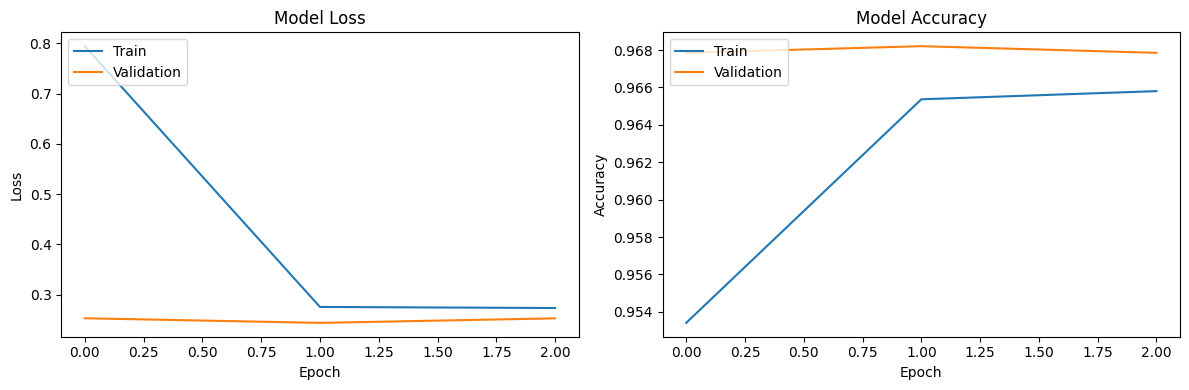

In [78]:
# Plot loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [79]:
 basic_rnn_model.save('/content/drive/My Drive/capstone/rnn_model_checkpoint.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
#Load the weights into the model
rnn_checkpoint_path = '/content/drive/My Drive/capstone/rnn_model_checkpoint.h5'
best_rnn_model=load_model(rnn_checkpoint_path)

In [81]:
train_loss, train_accuracy = basic_rnn_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = basic_rnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

63/63 [==============================] - 64s 1s/step - loss: 0.2532 - accuracy: 0.9678
Validation Loss: 0.2532498240470886, Validation Accuracy: 0.9678496718406677
Training Loss: 0.27440783381462097, Training Accuracy: 0.9651591181755066


In [82]:
accuracy = test_accuracy

In [83]:
rnn_results_df = pd.DataFrame({'Model': ['RNN'], 'Accuracy': [accuracy * 100]})
rnn_results_df

,Model,Accuracy
0,RNN,96.784967


In [84]:
random_indices = random.sample(range(len(test_german_padded)), 10)
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]
y_sample_pred = basic_rnn_model.predict(X_sample)
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]
for i in range(len(random_indices)):
    print(f"German {X_sample[i]}:")
    print(f"Actual:   {sample_actual_decoded[i]}")
    print(f"Predicted: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 301ms/step
German [   40    55    21 16470    22     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0    

Simple LSTM model

In [85]:
# Define the model
basic_lstm_model = Sequential()
basic_lstm_model.add(LSTM(256, input_shape=(max_len, 1), return_sequences=True))
basic_lstm_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
basic_lstm_model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
basic_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 645, 256)          264192    
                                                                 
 dense_6 (Dense)             (None, 645, 19340)        4970380   
                                                                 
Total params: 5234572 (19.97 MB)
Trainable params: 5234572 (19.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
#Define the callbacks
lstm_checkpoint_path = '/content/drive/MyDrive/capstone/lstm_model_checkpoint.h5'
lstm_checkpoint = ModelCheckpoint(
    filepath=lstm_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = basic_lstm_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=3,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[lstm_checkpoint, early_stopping]
)

Epoch 1/3
63/63 [==============================] - ETA: 0s - loss: 2.5153 - accuracy: 0.9628
Epoch 1: val_loss improved from inf to 0.25445, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 442s 7s/step - loss: 2.5153 - accuracy: 0.9628 - val_loss: 0.2544 - val_accuracy: 0.9679
Epoch 2/3
63/63 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9655
Epoch 2: val_loss improved from 0.25445 to 0.24276, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 438s 7s/step - loss: 0.2713 - accuracy: 0.9655 - val_loss: 0.2428 - val_accuracy: 0.9683
Epoch 3/3
63/63 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9661
Epoch 3: val_loss improved from 0.24276 to 0.24085, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 438s 7s/step - loss: 0.2669 - accuracy: 0.9661 - val_loss: 0.2408 - val_accuracy: 0.9684


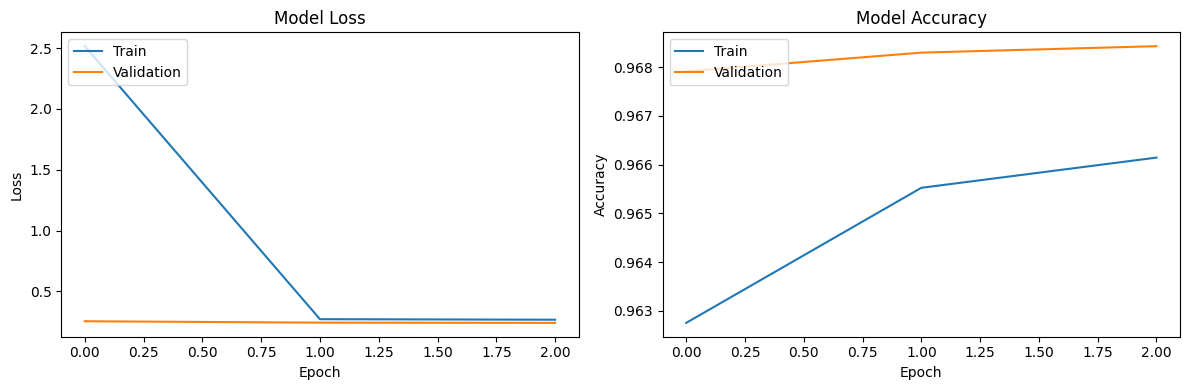

In [88]:
#Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [89]:
best_lstm_model = load_model(lstm_checkpoint_path)
best_lstm_model.load_weights(lstm_checkpoint_path)

In [90]:
test_loss, test_accuracy = basic_lstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

63/63 [==============================] - 80s 1s/step - loss: 0.2408 - accuracy: 0.9684


In [91]:
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

Validation Loss: 0.24084873497486115, Validation Accuracy: 0.9684271812438965


In [92]:
accuracy = test_accuracy

In [93]:
lstm_results_df = pd.DataFrame({'Model': ['LSTM'], 'Accuracy': [accuracy * 100]})
lstm_results_df

,Model,Accuracy
0,LSTM,96.842718


In [95]:
random_indices = random.sample(range(len(test_german_padded)), 10)
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]
y_sample_pred = best_lstm_model.predict(X_sample)

def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 1s 579ms/step
Example 1:
Actual English:   present extent of poses a threat to public security and to the global information society per se
Predicted English: is the the the the the the

Example 2:
Actual English:   ferri that was not a point of order
Predicted English: the the the the the

Example 3:
Actual English:   me come back to our task for the new century
Predicted English: the the the the the the

Example 4:
Actual English:   register now please enter your shareholder id and your initial access code
Predicted English: the the the the the the the

Example 5:
Actual English:   the same time european union countries must also be aware that it is in their interest for romania and bulgaria to join schengen because they will be able to make their own contribution to the security of all member states and extend the schengen area which is set to strengthen the integration process within the european union and the common area of freedom security a

In [96]:
# Combine RNN and LSTM results
combined_results_df = pd.concat([rnn_results_df, lstm_results_df], ignore_index=True)
combined_results_df

,Model,Accuracy
0,RNN,96.784967
1,LSTM,96.842718




```
# This is formatted as code
```

Complex models - Embedded, Bidirectional Models to evaluate MLT Milestone 2

In [ ]:
# Verify the shapes of the input data

print(f"The target sequences for Train are shifted by one time step: {train_english_padded_shifted.shape}")
print(f"The target sequences for Test are shifted by one time step: {test_english_padded_shifted.shape}")
print("")
print(f"Max length between max of english and german length: {max_len}")
print("")
print("German vocabulary is of {} unique words".format(german_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))
print("")
print(f"Shape of train_german_padded: {train_german_padded.shape}")
print(f"Shape of train_english_padded_shifted: {train_english_padded_shifted.shape}")
print(f"Shape of test_german_padded: {test_german_padded.shape}")
print(f"Shape of test_english_padded_shifted: {test_english_padded_shifted.shape}")

The target sequences for Train are shifted by one time step: (7964, 645)
The target sequences for Test are shifted by one time step: (1992, 645)

Max length between max of english and german length: 645

German vocabulary is of 29642 unique words
English vocabulary is of 19340 unique words

Shape of train_german_padded: (7964, 645)
Shape of train_english_padded_shifted: (7964, 645)
Shape of test_german_padded: (1992, 645)
Shape of test_english_padded_shifted: (1992, 645)


In [ ]:
# Define embedding dimensions (adjust as needed)
embedding_dim = 128

# Define RNN Model with Embeddings
def create_rnn_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_shape=(max_len,)))
  model.add(SimpleRNN(256, return_sequences=True))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

# Define LSTM Model with Embeddings
def create_lstm_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_shape=(max_len,)))
  model.add(LSTM(256, return_sequences=True))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [ ]:
print(german_vocab)

29642


In [ ]:
print(embedding_dim)

128


In [ ]:
print(max_len)

645


In [ ]:
# Create RNN and LSTM models with embeddings
embedded_rnn_model = create_rnn_model(german_vocab, embedding_dim)
embedded_lstm_model = create_lstm_model(german_vocab, embedding_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 645, 128)          3794176   
                                                                 
 simple_rnn (SimpleRNN)      (None, 645, 256)          98560     
                                                                 
 dense (Dense)               (None, 645, 19340)        4970380   
                                                                 
Total params: 8863116 (33.81 MB)
Trainable params: 8863116 (33.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 645, 128)          3794176   
                                                            

In [71]:
# # Train Embedded RNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_rnn = embedded_rnn_model.fit(
   train_german_padded,
   np.expand_dims(train_english_padded_shifted, -1),
   epochs=5,
   batch_size=128,
   validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
   callbacks=[early_stopping]
 )

Epoch 1/5
63/63 [==============================] - 370s 6s/step - loss: 2.2791 - accuracy: 0.9326 - val_loss: 0.9769 - val_accuracy: 0.9442
Epoch 2/5
63/63 [==============================] - 370s 6s/step - loss: 1.0311 - accuracy: 0.9399 - val_loss: 0.6551 - val_accuracy: 0.9556
Epoch 3/5
63/63 [==============================] - 370s 6s/step - loss: 0.4453 - accuracy: 0.9635 - val_loss: 0.3529 - val_accuracy: 0.9681
Epoch 4/5
63/63 [==============================] - 370s 6s/step - loss: 0.3862 - accuracy: 0.9659 - val_loss: 0.3505 - val_accuracy: 0.9681
Epoch 5/5
63/63 [==============================] - 371s 6s/step - loss: 0.4201 - accuracy: 0.9644 - val_loss: 0.4554 - val_accuracy: 0.9637


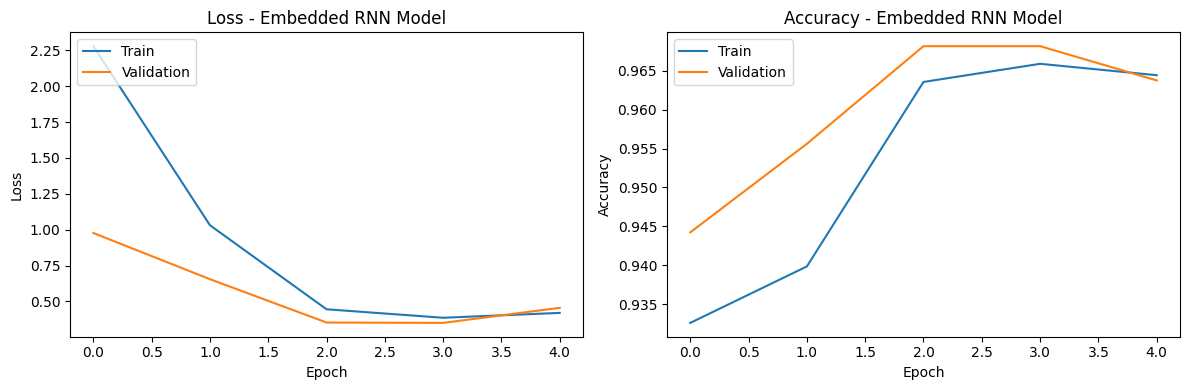

In [72]:
# Plot training & validation loss values for Embedded RNN Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Loss - Embedded RNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation accuracy values for Embedded RNN Model
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Accuracy - Embedded RNN Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [73]:
train_loss, train_accuracy = embedded_rnn_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = embedded_rnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Loss -Embedded RNN Training : {train_loss:.2f}, Accuracy - Embedded RNN Training : {train_accuracy*100:.2f}")
print(f"Loss - Embedded RNN Validation : {test_loss:.2f}, Accuracy - Embedded RNN : {test_accuracy*100:.2f}")
print(" ")

63/63 [==============================] - 65s 1s/step - loss: 0.4554 - accuracy: 0.9637
 
Loss -Embedded RNN Training : 0.54, Accuracy - Embedded RNN Training : 95.96
Loss - Embedded RNN Validation : 0.46, Accuracy - Embedded RNN : 96.37
 


In [ ]:
# Train Embedded LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_lstm = embedded_lstm_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[early_stopping]
)

Epoch 1/10
63/63 [==============================] - 458s 7s/step - loss: 2.4763 - accuracy: 0.9505 - val_loss: 0.3602 - val_accuracy: 0.9677
Epoch 2/10
63/63 [==============================] - 451s 7s/step - loss: 0.3795 - accuracy: 0.9658 - val_loss: 0.3404 - val_accuracy: 0.9682
Epoch 3/10
63/63 [==============================] - 451s 7s/step - loss: 0.5583 - accuracy: 0.9587 - val_loss: 0.3663 - val_accuracy: 0.9663
Epoch 4/10
63/63 [==============================] - 450s 7s/step - loss: 0.3758 - accuracy: 0.9646 - val_loss: 0.3383 - val_accuracy: 0.9672
Epoch 5/10
63/63 [==============================] - 453s 7s/step - loss: 0.3485 - accuracy: 0.9653 - val_loss: 0.3188 - val_accuracy: 0.9675
Epoch 6/10
63/63 [==============================] - 451s 7s/step - loss: 0.3289 - accuracy: 0.9657 - val_loss: 0.3008 - val_accuracy: 0.9679
Epoch 7/10
63/63 [==============================] - 451s 7s/step - loss: 0.3085 - accuracy: 0.9661 - val_loss: 0.2773 - val_accuracy: 0.9683
Epoch 8/10
63

In [ ]:
#Next steps are from sample soultion, we need to plot the graph for LSTM Embedding and evaluate.

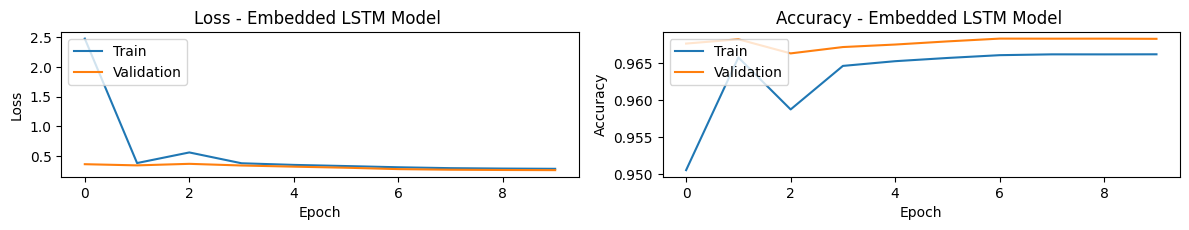

In [59]:
# Plot training & validation loss values for Embedded LSTM Model
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Loss - Embedded LSTM Model ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Embedded LSTM Model
plt.subplot(2, 2, 2)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Accuracy - Embedded LSTM Model ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [58]:
train_loss, train_accuracy = embedded_lstm_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = embedded_lstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Loss - Embedded LSTM Training : {train_loss:.2f}, Embedded LSTM Training Accuracy: {train_accuracy*100:.2f}")
print(f"Loss - Embedded LSTM Validation : {test_loss:.2f}, Embedded LSTM Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 83s 1s/step - loss: 0.2600 - accuracy: 0.9683
 
Loss - Embedded LSTM Training : 0.28, Embedded LSTM Training Accuracy: 96.62
Loss - Embedded LSTM Validation : 0.26, Embedded LSTM Accuracy: 96.83


In [63]:
embedding_dim = 128
# Define function to create BiRNN model with embeddings
def create_BRNN_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model



# Create BiRNN and BiLSTM models with embeddings
birnn_model = create_BRNN_model(german_vocab, embedding_dim)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 645, 128)          3794176   
                                                                 
 bidirectional_1 (Bidirecti  (None, 645, 512)          197120    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 645, 19340)        9921420   
                                                                 
Total params: 13912716 (53.07 MB)
Trainable params: 13912716 (53.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Define function to create BiLSTM model with embeddings
def create_BLSTM_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(256, return_sequences=True)))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [65]:
bilstm_model = create_BLSTM_model(german_vocab, embedding_dim)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 645, 128)          3794176   
                                                                 
 bidirectional_2 (Bidirecti  (None, 645, 512)          788480    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 645, 19340)        9921420   
                                                                 
Total params: 14504076 (55.33 MB)
Trainable params: 14504076 (55.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# Train BiRNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_birnn = birnn_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=5,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[early_stopping]
)

Epoch 1/5
63/63 [==============================] - 427s 7s/step - loss: 2.4384 - accuracy: 0.8781 - val_loss: 0.5074 - val_accuracy: 0.9681
Epoch 2/5
63/63 [==============================] - 424s 7s/step - loss: 0.4730 - accuracy: 0.9646 - val_loss: 0.3903 - val_accuracy: 0.9666
Epoch 3/5
63/63 [==============================] - 423s 7s/step - loss: 0.4226 - accuracy: 0.9647 - val_loss: 0.3735 - val_accuracy: 0.9681
Epoch 4/5
63/63 [==============================] - 425s 7s/step - loss: 0.4048 - accuracy: 0.9660 - val_loss: 0.3539 - val_accuracy: 0.9681
Epoch 5/5
63/63 [==============================] - 423s 7s/step - loss: 0.3605 - accuracy: 0.9660 - val_loss: 0.2941 - val_accuracy: 0.9681


In [67]:
# Train BiLSTM model
history_bilstm = bilstm_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=5,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[early_stopping]
)

Epoch 1/5
63/63 [==============================] - 540s 9s/step - loss: 1.9201 - accuracy: 0.9501 - val_loss: 0.3196 - val_accuracy: 0.9681
Epoch 2/5
63/63 [==============================] - 533s 8s/step - loss: 0.3070 - accuracy: 0.9660 - val_loss: 0.2527 - val_accuracy: 0.9681
Epoch 3/5
63/63 [==============================] - 534s 8s/step - loss: 0.2766 - accuracy: 0.9660 - val_loss: 0.2475 - val_accuracy: 0.9681
Epoch 4/5
63/63 [==============================] - 533s 8s/step - loss: 0.2740 - accuracy: 0.9660 - val_loss: 0.2473 - val_accuracy: 0.9681
Epoch 5/5
63/63 [==============================] - 532s 8s/step - loss: 0.2729 - accuracy: 0.9660 - val_loss: 0.2470 - val_accuracy: 0.9681


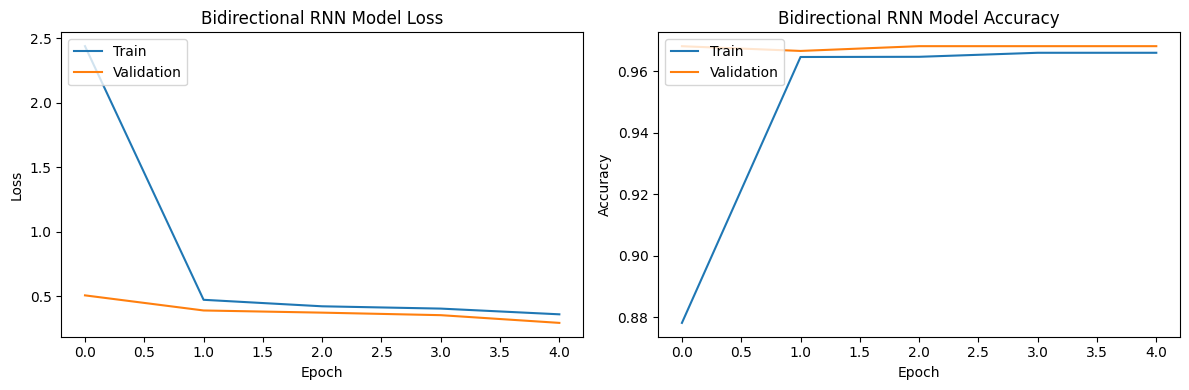

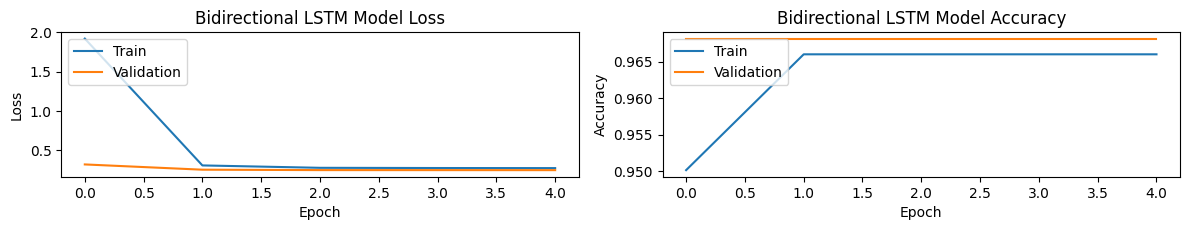

In [68]:
# Plot training & validation loss values for Bidirectional RNN Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_birnn.history['loss'])
plt.plot(history_birnn.history['val_loss'])
plt.title('Bidirectional RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Bidirectional RNN Model
plt.subplot(1, 2, 2)
plt.plot(history_birnn.history['accuracy'])
plt.plot(history_birnn.history['val_accuracy'])
plt.title('Bidirectional RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation loss values for Bidirectional LSTM Model
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Bidirectional LSTM Model
plt.subplot(2, 2, 2)
plt.plot(history_bilstm.history['accuracy'])
plt.plot(history_bilstm.history['val_accuracy'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [69]:
train_loss, train_accuracy = birnn_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = birnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Bidirectional RNN Training Loss: {train_loss:.2f}, Bidirectional RNN Training Accuracy: {train_accuracy*100:.2f}")
print(f"Bidirectional RNN Validation Loss: {test_loss:.2f}, Bidirectional RNN Accuracy: {test_accuracy*100:.2f}")
print(" ")
train_loss, train_accuracy = bilstm_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = bilstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Bidirectional LSTM Training Loss: {train_loss:.2f}, Bidirectional LSTM Training Accuracy: {train_accuracy*100:.2f}")
print(f"Bidirectional LSTM Validation Loss: {test_loss:.2f}, Bidirectional LSTM Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 69s 1s/step - loss: 0.2941 - accuracy: 0.9681
 
Bidirectional RNN Training Loss: 0.33, Bidirectional RNN Training Accuracy: 96.60
Bidirectional RNN Validation Loss: 0.29, Bidirectional RNN Accuracy: 96.81
 
63/63 [==============================] - 89s 1s/step - loss: 0.2470 - accuracy: 0.9681
 
Bidirectional LSTM Training Loss: 0.27, Bidirectional LSTM Training Accuracy: 96.60
Bidirectional LSTM Validation Loss: 0.25, Bidirectional LSTM Accuracy: 96.81
